# Accelerometer time series classification

In this notebook four approaches to multivariate time-series will be evaluated:
- Recurrence plot features (both as recurrence thresholded matrix and distance matrix)
- Paired recurrence plot features
- Spectrogram features
- Scaleogram features

3D features arrays will be placed as input of 2D Convolutional Neural Networks for a binary classification task.

In [1]:
# Install packages
!pip install ssqueezepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 29.3 MB/s 


In [2]:
# Check if tensorflow finds the runtime GPU
import tensorflow as tf


print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

2.8.2
Found GPU at: /device:GPU:0


In [3]:
# Clone the repository

Cloning into 'fc_crash-detection'...
remote: Enumerating objects: 18779, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 18779 (delta 13), reused 9 (delta 4), pack-reused 18749
Receiving objects: 100% (18779/18779), 2.00 GiB | 17.40 MiB/s, done.
Resolving deltas: 100% (835/835), done.
Checking out files: 100% (16051/16051), done.


In [4]:
# Mount Google Drive
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set params
dataset_path = '/content/fc_crash-detection/crash-dataset-csv/microbox'
test_dataset_path = '/content/drive/MyDrive/2d_microbox_dataset' # Where to save test set
results_path = '/content/drive/MyDrive'
model_name = 'microbox_scaleogram_xyz_300_1' # In results_path
mode = 'scaleogram' # recurrence_plot, paired_recurrence_plot, spectrogram, scaleogram
test_split = 0.2
validation_split = 0.1
max_epoch = 1000
batch_size = 16
min_delta = 0
patience = 30

In [6]:
# Define some functions
from scipy import signal
from tqdm.notebook import tqdm
from ssqueezepy import cwt
import numpy as np
import pandas as pd
import sklearn.metrics
import glob
import os


def recurrence_plot(s1, s2, threshold):
  eps=0.1 # Scaling factor
  if s2 is None:
    d = sklearn.metrics.pairwise.pairwise_distances(s1)
    d = np.floor(d / eps)
    if threshold > 0:
      d = np.where(d > threshold,1,0)
    return d
  else:
    d = sklearn.metrics.pairwise.pairwise_distances(s1, s2) # Paired recurrence matrix
    d = np.floor(d / eps)
    if threshold > 0:
      d = np.where(d > threshold,1,0)
    return d


def specg(s):
  eps = 1e-10
  fs = 1e3
  f, t, S = signal.spectrogram(s,
                                fs,
                                window = 'hamming',
                                nperseg = 128,
                                noverlap = 96,
                                nfft = 128)

  return np.log(S + eps)


def get_dataset(path, mode, threshold=-1):
  entry_list = []
  files_list = glob.glob(os.path.join(path, "*.csv"))
  # Load every csv inside path as a numpy matrix, preprocess and create a list
  for filename in tqdm(files_list):
    ds_entry = pd.read_csv(filename, index_col=None, header=0)

    if mode == 'recurrence_plot': 
      loaded_entry = ds_entry.values[1:3000,4:7] # numpy slicing [start:stop:step]
      ds_entry_processed = loaded_entry[::30].copy() # Subsample 1 every 30 samples

      d_x = recurrence_plot(ds_entry_processed[:,0,None], None, threshold)
      d_y = recurrence_plot(ds_entry_processed[:,1,None], None, threshold)
      d_z = recurrence_plot(ds_entry_processed[:,2,None], None, threshold)

    if mode == 'paired_recurrence_plot':
      loaded_entry = ds_entry.values[1:3000,4:7] # numpy slicing [start:stop:step]
      ds_entry_processed = loaded_entry[::30].copy() # Subsample 1 every 30 samples

      d_x = recurrence_plot(ds_entry_processed[:,0,None], ds_entry_processed[:,1,None], threshold) # X-Y
      d_y = recurrence_plot(ds_entry_processed[:,1,None], ds_entry_processed[:,2,None], threshold) # Y-Z
      d_z = recurrence_plot(ds_entry_processed[:,0,None], ds_entry_processed[:,2,None], threshold) # X-Z

    if mode == 'spectrogram':
      loaded_entry = ds_entry.values[1:3000,4:7] # numpy slicing [start:stop:step]
      ds_entry_processed = loaded_entry[::1].copy() # No subsample

      d_x = specg(ds_entry_processed[:,0].astype(float))
      d_y = specg(ds_entry_processed[:,1].astype(float))
      d_z = specg(ds_entry_processed[:,2].astype(float))

    if mode == 'scaleogram':
      loaded_entry = ds_entry.values[1:3000,4:7] # numpy slicing [start:stop:step]
      ds_entry_processed = loaded_entry[::10].copy() # Subsample 1 every 10 samples

      W_x, scales_x = cwt(ds_entry_processed[:,0].astype(float), 'morlet')
      W_y, scales_y = cwt(ds_entry_processed[:,1].astype(float), 'morlet')
      W_z, scales_z = cwt(ds_entry_processed[:,2].astype(float), 'morlet')

      d_x = np.absolute(W_x)
      d_y = np.absolute(W_y)
      d_z = np.absolute(W_z)

    d_all = np.stack([d_x, d_y, d_z], axis=2)
    entry_list.append(d_all)
  ds_array = np.stack(entry_list)

  return ds_array

In [7]:
# Load data
import numpy as np


#ds_false = get_dataset(dataset_path + '/false', mode='recurrence_plot', threshold = 10)
ds_false = get_dataset(dataset_path + '/false', mode=mode)
ds_true = get_dataset(dataset_path + '/true', mode= mode)

# Build all-false labels (one hot encoding, two classes, two columns)
ds_false_labels = np.zeros((len(ds_false),2))
# Set all first column to one
ds_false_labels[:,0] = 1
print("False-class data:")
print(ds_false.shape)
print(ds_false_labels.shape)

# Build all-true labels (one hot encoding, two classes, two columns)
ds_true_labels = np.zeros((len(ds_true),2))
# Set all second column to one
ds_true_labels[:,1] = 1
print("\nTrue-class data:")
print(ds_true.shape)
print(ds_true_labels.shape)

# Concatenate false-class/true-class data and labels
ds_all = np.concatenate((ds_false, ds_true), axis = 0)
ds_all_labels = np.concatenate((ds_false_labels, ds_true_labels), axis = 0)
print("\nAll data:")
print(ds_all.shape)
print(ds_all_labels.shape)
del ds_false, ds_true, ds_false_labels, ds_true_labels

  0%|          | 0/962 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


  0%|          | 0/962 [00:00<?, ?it/s]

False-class data:
(962, 222, 300, 3)
(962, 2)

True-class data:
(962, 222, 300, 3)
(962, 2)

All data:
(1924, 222, 300, 3)
(1924, 2)


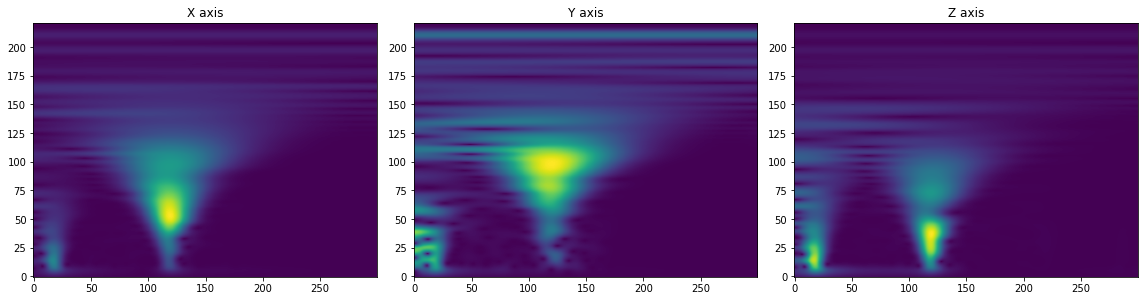

In [ ]:
# Plot a single sample of data
from matplotlib import pyplot as plt
import random


sample = random.randint(0, ds_all.shape[0])

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(ds_all[sample,:,:,0], origin='low')
plt.title('X axis')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(ds_all[sample,:,:,1], origin='low')
plt.title('Y axis')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(ds_all[sample,:,:,2], origin='low')
plt.title('Z axis')

plt.tight_layout()
plt.show()

In [8]:
# Create train and test splits
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(ds_all, ds_all_labels, test_size = test_split)

print("Train split:")
print(X_train.shape)
print(y_train.shape)

print("\nTest split:")
print(X_test.shape)
print(y_test.shape)

Train split:
(1539, 222, 300, 3)
(1539, 2)

Test split:
(385, 222, 300, 3)
(385, 2)


In [9]:
# Create the model
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten


# Model definition
model = tf.keras.models.Sequential()

input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])
model.add(Conv2D(64, (6,6), activation='elu', strides=(1,1), dilation_rate=2 , input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(6,6)))
#model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), activation='elu', strides=(1,1), dilation_rate=1))
model.add(MaxPooling2D(pool_size=(3,3)))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Define optimizer, learning rate, and compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy', 'AUC'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 212, 290, 64)      6976      
                                                                 
 batch_normalization (BatchN  (None, 212, 290, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 46, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 15, 64)       0         
 2D)                                                             
                                                        

Epoch 1/1000
87/87 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8159 - auc: 0.8866
Epoch 1: val_accuracy improved from -inf to 0.81818, saving model to /content/microbox_scaleogram_xyz_300_1.h5
87/87 [==============================] - 24s 84ms/step - loss: 0.4727 - accuracy: 0.8159 - auc: 0.8866 - val_loss: 0.6305 - val_accuracy: 0.8182 - val_auc: 0.8689
Epoch 2/1000
86/87 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8626 - auc: 0.9246
Epoch 2: val_accuracy improved from 0.81818 to 0.84416, saving model to /content/microbox_scaleogram_xyz_300_1.h5
87/87 [==============================] - 6s 73ms/step - loss: 0.3656 - accuracy: 0.8628 - auc: 0.9250 - val_loss: 0.5759 - val_accuracy: 0.8442 - val_auc: 0.8855
Epoch 3/1000
86/87 [============================>.] - ETA: 0s - loss: 0.3389 - accuracy: 0.8677 - auc: 0.9321
Epoch 3: val_accuracy improved from 0.84416 to 0.88961, saving model to /content/microbox_scaleogram_xyz_300_1.h5
87/87 

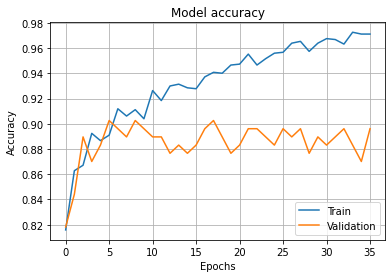

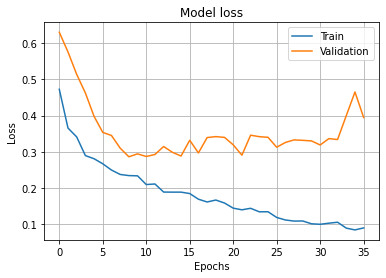

In [10]:
# Train
from matplotlib import pyplot as plt
import tensorflow as tf


checkpoint = tf.keras.callbacks.ModelCheckpoint(results_path + '/' + model_name + '.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=min_delta, patience=patience, verbose=1, mode='auto')

history = model.fit(X_train, y_train, validation_split = validation_split, batch_size = batch_size, epochs = max_epoch, callbacks = [checkpoint, early], shuffle = True)

# Accuracy
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
fig1.savefig(results_path + '/' + model_name + '_model_accuracy.png')
plt.show()
# Loss
fig2 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
fig2.savefig(results_path + '/' + model_name + '_model_loss.png')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 212, 290, 64)      6976      
                                                                 
 batch_normalization (BatchN  (None, 212, 290, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 46, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 15, 64)       0         
 2D)                                                             
                                                        

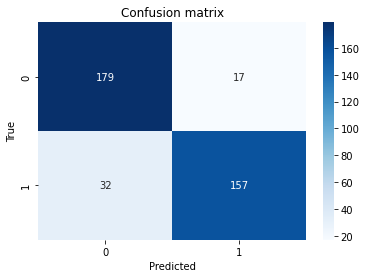

In [11]:
# Test
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from tensorflow import keras
import seaborn as sns
import pandas as pd


model = keras.models.load_model(results_path + '/' + model_name + '.h5')
model.summary()
results = model.evaluate(X_test, y_test)

print('\nTest Loss, Test Accuracy, Test AUC:', results)

# Generate confusion matrix and compute metrics
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred)
tn, fp, fn, tp = conf_mat.ravel()
precision = precision_score(y_test.argmax(axis=1), y_pred)
recall = recall_score(y_test.argmax(axis=1), y_pred)
f1_score = f1_score(y_test.argmax(axis=1), y_pred)

print('\nPrecision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(f1_score))
print('\nTrue Negatives: ' + str(tn))
print('False Positives: ' + str(fp))
print('False Negatives: ' + str(fn))
print('True Positives: ' + str(tp) + '\n')

fig = plt.figure()
sns.heatmap(conf_mat, annot=True, fmt="d",cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
fig.savefig(results_path + '/' + model_name + '_confusion_matrix.png')
plt.show()

data = {'a': [results[0], results[1], results[2], precision, recall, f1_score, tn, fp, fn, tp]}
df = pd.DataFrame(data=data, index=['Test Loss', 'Test Accuracy', 'Test AUC', 'Precision', 'Recall', 'F1-score', 'True Negatives', 'False Positives', 'False Negatives', 'True Positives'])
df.to_csv(results_path + '/' + model_name + '_results.csv', header=False)

In [ ]:
# Save test dataset 
import csv
import os


if len(os.listdir(test_dataset_path + '/false')) == 0 and len(os.listdir(test_dataset_path + '/true')) == 0:
  for i in range(0,len(X_test)):
    if y_test[i][1] == 1:
      test_class = "true"
    else:
      test_class = "false"
    with open(test_dataset_path + '/' + test_class + '/' + test_class + '_' + str(i+1) + '.csv', 'w') as csvfile:
      writer = csv.writer(csvfile)
      for j in range(0, len(X_test[i])):
        row = []
        for k in range(0, len(X_test[i][j])):
          val = str(X_test[i][j][k][0])
          row.append(val)
        writer.writerow(row)
      for n in range(0, len(X_test[i])):
        row = []
        for z in range(0, len(X_test[i][n])):
          val = str(X_test[i][n][z][1])
          row.append(val)
        writer.writerow(row)
      for x in range(0, len(X_test[i])):
        row = []
        for y in range(0, len(X_test[i][x])):
          val = str(X_test[i][x][y][2])
          row.append(val)
        writer.writerow(row)